### Loading packages

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"

import theano

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


### Loading surface points from repository:

With pandas we can do it directly from the web and with the right args we can directly tidy the data in gempy style:

In [2]:
dfs = []

# First stratigraphic data
for letter in range(1,10):
    if letter == 3 or letter ==6 or letter == 8:
        pass
    else:
        dfs.append(pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Hecho/Sparse/H'+
                               str(letter)+'.csv', sep=';',
                             names=['X', 'Y', 'Z', 'surface', '_'], header=0))
# Also faults
for f in range(1,4):
    fault_df = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Hecho/F'+
                           str(f)+'Line.csv',
                  sep=';', names=['X', 'Y', 'Z'], header=0)
    fault_df['surface'] = 'f'+str(f)
    dfs.append(fault_df)        

# We put all the surfaces points together because is how gempy likes it:
surface_points = pn.concat(dfs, sort=True)
surface_points.reset_index(inplace=True, drop=False)
surface_points.tail()

,index,X,Y,Z,_,surface
402,6,11.143734,-0.172893,1.53226,NaN,f3
403,7,11.171513,0.284198,1.68442,NaN,f3
404,8,11.159113,0.399711,1.81939,NaN,f3
405,9,11.069008,0.032232,1.92030,NaN,f3
406,10,10.885192,-0.428004,2.10412,NaN,f3


Now we do the same with the orientations:

In [3]:
orientations = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Hecho/Sparse/Dips.csv', sep=';',
                names=['X', 'Y', 'Z', 'G_x', 'G_z', '_'], header=0)
# Orientation needs to belong to a surface. This is mainly to categorize to which series belong and to
# use the same color
orientations['surface'] = 0

# We fill the laking direction with a dummy value:
orientations['G_y'] = 0

# Drop unecesary data point
orientations.drop([1,3,4], inplace=True)
orientations

,X,Y,Z,G_x,G_z,_,surface,G_y
0,3.812638,0.163828,0.584748,0.619147,0.785275,4,0,0
2,9.870857,0.058731,2.520195,-0.764469,0.644660,20,0,0
5,4.831136,-0.031274,3.328896,0.067834,0.997697,28,0,0


### Data initialization:

Suggested size of the axis-aligned modeling box: Origin: 0 -0.5 0 Maximum: 16 0.5 4.5

Suggested resolution: 0.05m (grid size 321 x 21 x 91)

In [4]:
geo_model = gp.create_model('Moureze')
geo_model = gp.init_data(geo_model, extent= [0, 16, -0.5, 0.5, 0, 4.5], resolution=[321, 21, 91],
                         surface_points_df=surface_points, orientations_df=orientations,
                         surface_name='surface',
                         add_basement=True)

Active grids: ['regular']


In [5]:
geo_model.orientations.df.at[5, 'surface']

0.0

In [6]:
geo_model.orientations.df

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,3.812638,0.163828,0.584748,0.358240,0.505594,0.446939,0.619147,0.0,0.785275,38.253880,90.0,1,0,Default series,1,1,0.01
2,9.870857,0.058731,2.520195,0.561699,0.502065,0.511939,-0.764469,0.0,0.644660,49.859812,270.0,1,0,Default series,1,1,0.01
5,4.831136,-0.031274,3.328896,0.392445,0.499042,0.539098,0.067834,0.0,0.997697,3.889269,90.0,1,0,Default series,1,1,0.01


We need an orientation per series/fault. The faults does not have orientation so the easiest is to create an orientation from the surface points availablle:

In [7]:
f_names = ['f1','f2','f3']
for fn in f_names:
    fault_idx = geo_model.surface_points.df.index[geo_model.surface_points.df['surface'] ==fn]
    gp.set_orientation_from_surface_points(geo_model, fault_idx)

../../../gempy/core/data.py:1808: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Now we can see how the data looks so far:

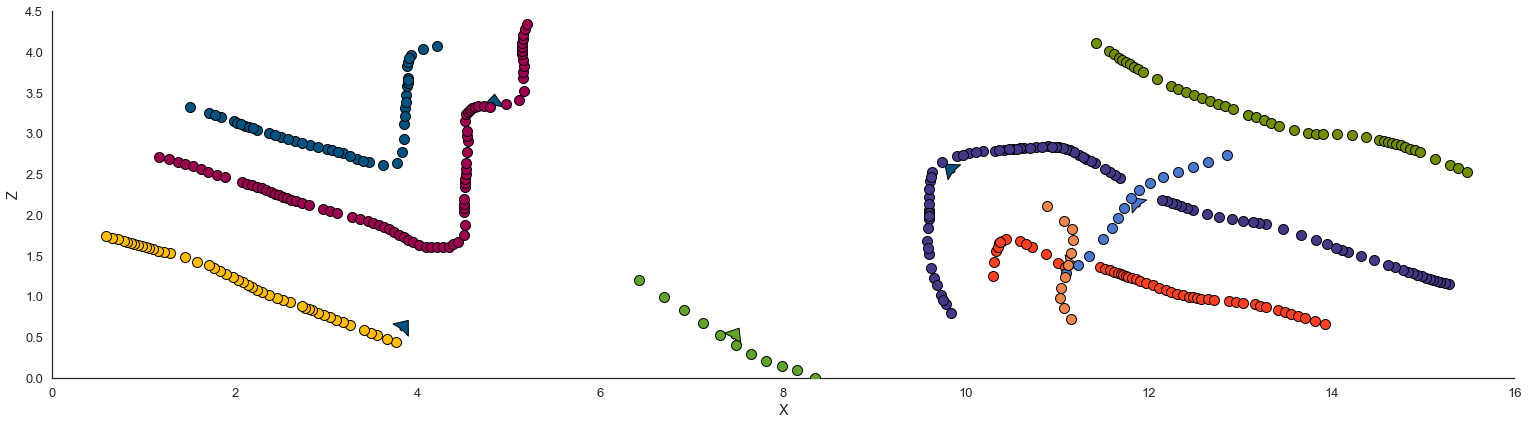

In [8]:
gp.plot.plot_data(geo_model)

By default all surfaces belong to one unique series.

In [9]:
geo_model.surfaces

,surface,series,order_surfaces,isActive,color,id
0,0,Default series,1,True,#015482,1
1,0.78,Default series,2,True,#9f0052,2
2,1.9,Default series,3,True,#ffbe00,3
3,2.5,Default series,4,True,#728f02,4
4,3.9,Default series,5,True,#443988,5
5,5.2,Default series,6,True,#ff3f20,6
6,f1,Default series,7,True,#5DA629,7
7,f2,Default series,8,True,#4878d0,8
8,f3,Default series,9,True,#ee854a,9
9,basement,Basement,1,True,#6acc64,10


In [10]:
geo_model.orientations.df.dtypes

X                float64
Y                float64
Z                float64
X_r              float64
Y_r              float64
Z_r              float64
G_x              float64
G_y              float64
G_z              float64
dip              float64
azimuth          float64
polarity           int64
surface         category
series          category
id                 int64
order_series       int64
smooth           float64
dtype: object

We will need to separate with surface belong to each series:

In [11]:
gp.map_series_to_surfaces(geo_model, {'Fault1':'f1', 'Fault2':'f2', 'Fault3':'f3'})

,surface,series,order_surfaces,isActive,color,id
0,0,Default series,1,True,#015482,1
1,0.78,Default series,2,True,#9f0052,2
2,1.9,Default series,3,True,#ffbe00,3
3,2.5,Default series,4,True,#728f02,4
4,3.9,Default series,5,True,#443988,5
5,5.2,Default series,6,True,#ff3f20,6
6,f1,Fault1,1,True,#5DA629,7
7,f2,Fault2,1,True,#4878d0,8
8,f3,Fault3,1,True,#ee854a,9
9,basement,Basement,1,True,#6acc64,10


However if we want the faults to offset the "Default series", they will need to be more recent (higher on the pile). We can modify the order by:

In [12]:
geo_model.modify_order_series(4, 'Default series')

,order_series,BottomRelation,isActive
Fault3,1,Erosion,True
Fault1,2,Erosion,True
Fault2,3,Erosion,True
Default series,4,Erosion,True
Basement,5,Erosion,False


Lastly, so far we did not specify which series/faults are actula faults:

In [13]:
geo_model.set_is_fault(['Fault1', 'Fault2', 'Fault3'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault3,True,False
Fault1,True,False
Fault2,True,False
Default series,False,False
Basement,False,False


Now we are good to go:

In [14]:
gp.set_interpolation_data(geo_model,theano_optimizer='fast_run', dtype='float32')

Setting kriging parameters to their default values.
Compiling theano function...


/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  3
Compilation Done!
Kriging values: 
                           values
range                    16.6508
$C_o$                    6.60119
drift equations  [3, 3, 3, 3, 3]


The default range is always the diagonal of the extent. Since in this model data is very close we will need to reduce the range to 5-10% of that value:

In [15]:
geo_model.interpolator.theano_graph.a_T.get_value()
geo_model.interpolator.theano_graph.a_T.set_value(.2)

In [16]:
gp.compute_model(geo_model, sort_surfaces=True, compute_mesh=False)

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=1.97789e-09): result may not be accurate.
  rval = scipy.linalg.solve(A, b)



Lithology ids 
  [10. 10. 10. ...  6.  6.  6.] 

### Time
- GTX 2080 164 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


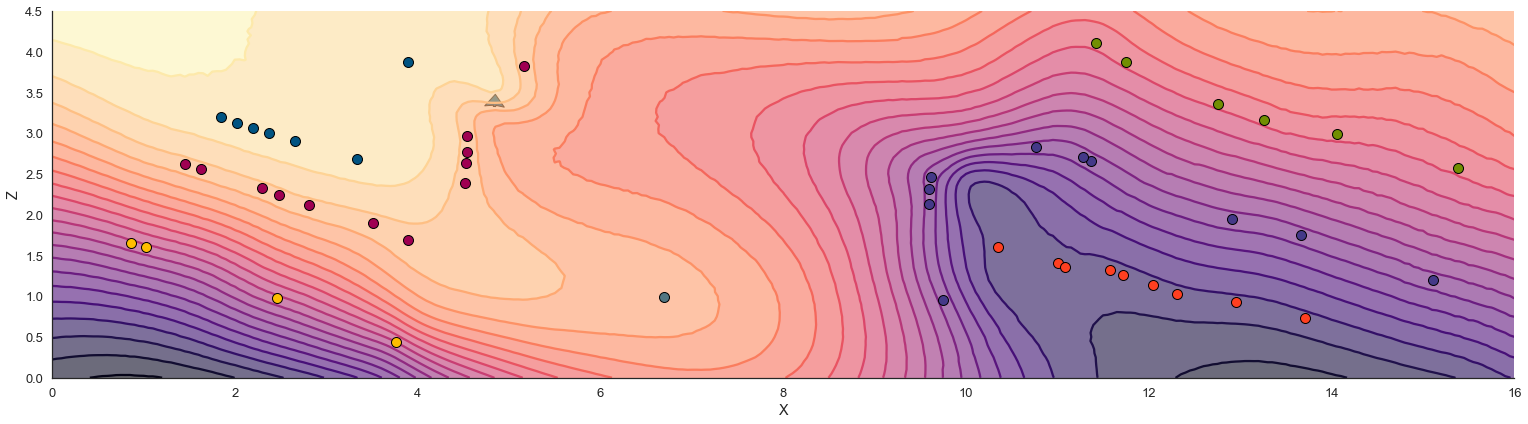

In [17]:
gp.plot.plot_scalar_field(geo_model, 10, series=3)

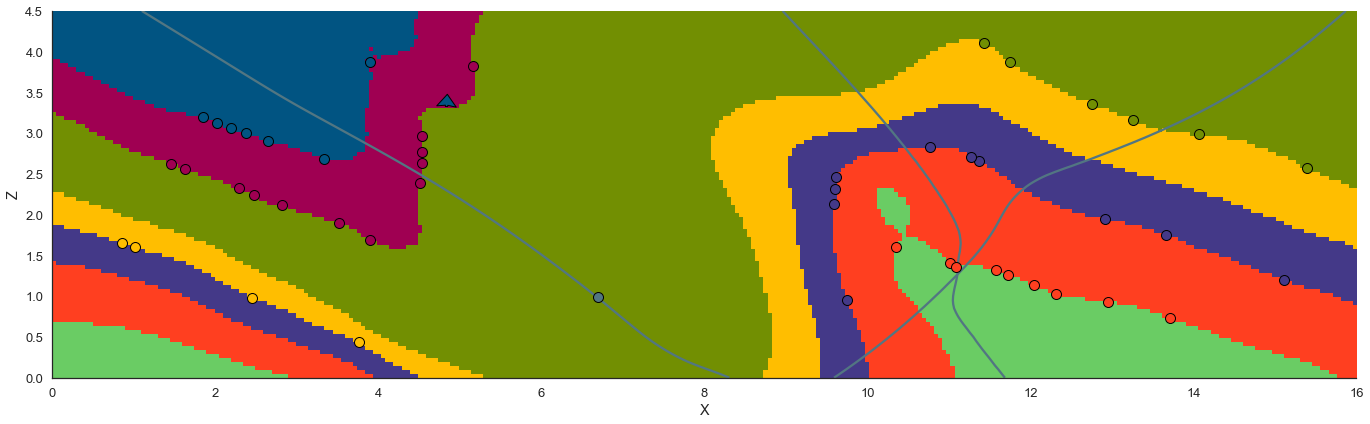

In [18]:
gp.plot.plot_section(geo_model, 10,  show_faults=True, show_data=True)

In [19]:
# gp.plot.plot_3D(geo_model)

### Export data:

The solution is stored in a numpy array of the following shape. Axis 0 are the scalar fields of each correspondent series/faults in the following order (except basement): 

In [20]:
geo_model.series

,order_series,BottomRelation,isActive
Fault3,1,Fault,True
Fault1,2,Fault,True
Fault2,3,Fault,True
Default series,4,Erosion,True
Basement,5,Erosion,False


For the surfaces, there are two numpy arrays, one with vertices and the other with triangles. Axis 0 is each surface in the order:

In [21]:
geo_model.surfaces

,surface,series,order_surfaces,isActive,color,id
8,f3,Fault3,1,True,#527682,1
6,f1,Fault1,1,True,#527682,2
7,f2,Fault2,1,True,#527682,3
0,0,Default series,1,True,#015482,4
1,0.78,Default series,2,True,#9f0052,5
3,2.5,Default series,3,True,#728f02,6
2,1.9,Default series,4,True,#ffbe00,7
4,3.9,Default series,5,True,#443988,8
5,5.2,Default series,6,True,#ff3f20,9
9,basement,Basement,1,True,#6acc64,10


In [22]:
np.save('Hecho_scalar', geo_model.solutions.scalar_field_matrix)

In [26]:
def write_property_to_gocad_voxet(propertyfilename, propertyvalues):
    """
    This function writes a numpy array into the right format for a gocad
    voxet property file. This assumet there is a property already added to the .vo file,
    and is just updating the file.
    propertyfile - string giving the path to the file to write
    propertyvalues - numpy array nz,ny,nx ordering and in float format
    """
    propertyvalues = propertyvalues.astype('>f4') #big endian
#     array = propertyvalues.newbyteorder()
    propertyvalues.tofile(propertyfilename)

In [27]:
write_property_to_gocad_voxet('hecho_sf_gempy',
                              geo_model.solutions.scalar_field_matrix[3].reshape([321, 21, 91]).ravel('F'))